In [1]:
from bs4 import BeautifulSoup
import requests

In [2]:
def get_mpaa_url(offset_nums):
    main_url = 'https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?by_mpaa=PG&offset={}'
    url_list = []
    for num in offset_nums:
        mpaa_url = main_url.format(num)
        url_list.append(mpaa_url)
    return url_list
offset_nums = [600,800,1000,1200,1400]
main_url_list = get_mpaa_url(offset_nums)
main_url_list


['https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?by_mpaa=PG&offset=600',
 'https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?by_mpaa=PG&offset=800',
 'https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?by_mpaa=PG&offset=1000',
 'https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?by_mpaa=PG&offset=1200',
 'https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?by_mpaa=PG&offset=1400']

In [22]:
from itertools import chain
import time
full_link = []
for mpaa_url in main_url_list:
    user_agent = {'User-agent': 'Mozilla/5.0'}
    mpaa_response = requests.get(mpaa_url,headers=user_agent)
    mpaa_page = mpaa_response.text
    mpaa_soup = BeautifulSoup(mpaa_page, "lxml")
    mpaa_table = mpaa_soup.find('table')
    rows=[]
    for full_row in mpaa_table.find_all('tr'):
        rows.append(full_row)
    complete_link=[]
    for row in rows[1:201]:
        items = row.find_all('td')
        items_link = items[0].find('a')
        link = items_link['href']
        link = link.split('?')
        link = link[0]
        complete_link.append(link)
        time.sleep(2)
    full_link.append(complete_link)
full_link = list(chain.from_iterable(full_link))
print(full_link)
print(len(full_link))

['/title/tt0250720/', '/title/tt0090142/', '/title/tt2555736/', '/title/tt0084827/', '/title/tt0108037/', '/title/tt0092494/', '/title/tt0418647/', '/title/tt0122459/', '/title/tt0317132/', '/title/tt0094606/', '/title/tt0132477/', '/title/tt0091653/', '/title/tt0106226/', '/title/tt0074174/', '/title/tt0106613/', '/title/tt0075029/', '/title/tt0078723/', '/title/tt0095800/', '/title/tt0426931/', '/title/tt0433383/', '/title/tt0076141/', '/title/tt1430626/', '/title/tt0087078/', '/title/tt0119303/', '/title/tt0093779/', '/title/tt0110093/', '/title/tt7961060/', '/title/tt0110442/', '/title/tt0109287/', '/title/tt0077869/', '/title/tt0078950/', '/title/tt0117608/', '/title/tt0078841/', '/title/tt2247476/', '/title/tt0113114/', '/title/tt0080801/', '/title/tt0123987/', '/title/tt7424200/', '/title/tt0093148/', '/title/tt0086005/', '/title/tt0086491/', '/title/tt0120185/', '/title/tt0361467/', '/title/tt0406375/', '/title/tt1415283/', '/title/tt0103596/', '/title/tt0116683/', '/title/tt01

In [30]:
import re
import numpy as np
import time
def get_movie_dict(link):
    try:
        base_url = 'https://www.boxofficemojo.com' 
        url = base_url + link
        user_agent = {'User-agent': 'Mozilla/5.0'}
    
        #Request HTML and parse
        response = requests.get(url,headers=user_agent)
        page = response.text
        soup = BeautifulSoup(page, "lxml")
    
        crew_url = url + 'credits'
        crew_response = requests.get(crew_url,headers=user_agent)
        crew_page = crew_response.text
        crew_soup = BeautifulSoup(crew_page, "lxml")
      
        rankings_url = url +'rankings'
        rankings_response = requests.get(rankings_url,headers=user_agent)
        rankings_page = rankings_response.text
        rankings_soup = BeautifulSoup(rankings_page, "lxml")
  
        headers= ['title','MPAA_rate', 'domestic_gross_pay', 'worldwide_gross_pay' ,'budget' , 'lifetime_ranking', 'running_time',
              'distributor','genre','top_director','top_actor']
    
        #Get Title
        global the_title
        old_title = soup.find('title').text.split('Box')[0]
        if old_title[-2] == '-':
            old_title = old_title[:-2]
            the_title = old_title
    
        #Get MPAA rate
        try:
            rate_string = soup.find(text=re.compile('MPAA'))
            rate = rate_string.findNext()
            rate = rate.text
        except:
            rate = 'PG'
    
        #Get Gross Domestic Pay
        try:
            gross_domestic_pay = soup.find('div',class_='mojo-performance-summary-table').find_all('span', class_='money')[0].text
            gross_domestic_pay = gross_domestic_pay.split('$')[1]
            gross_domestic_pay = gross_domestic_pay.replace(',','')
            gross_domestic_pay = int(gross_domestic_pay)
        except:
            gross_domestic_pay = np.nan
        
        #Find Gross Pay Worldwide 
        try:
            gross_worldwide_pay = soup.find('div', class_='mojo-performance-summary-table').find_all('span',class_='money')[2].text
            gross_worldwide_pay = gross_worldwide_pay.split('$')[1]
            gross_worldwide_pay = gross_worldwide_pay.replace(',','')
            gross_worldwide_pay = int(gross_worldwide_pay)
        except:
            gross_worldwide_pay = np.nan
        
        #Get Budget
        try:
            budget_string = soup.find(text=re.compile('Budget'))
            budget = budget_string.findNext()
            budget = budget.text
            budget = budget.split('$')[1]
            budget = budget.replace(',','')
            budget = int(budget)
        except:
            budget = np.nan
    
        #Top Lifetime Ranking by MPAA Rating
        try:
            rankings = rankings_soup.find(text=re.compile('Top Lifetime Grosses by MPAA Rating'))
            rankings = rankings.findNext().text
            rankings = int(rankings)
        except:
            rankings = np.nan
        
        #Get Running Time
        try:
            rt_string = (soup.find(text=re.compile('Running Time')))
            rt = rt_string.findNext().text
            rt = rt.split()
            minutes = int(rt[0])*60 + int(rt[2])
        except:
            minutes = np.nan

        #Get Distributor
        try:
            dist_string = soup.find('div',class_="mojo-summary-values").find_all('span')
            dist = dist_string[1].text
            dist = dist.replace("See full company information", '').replace('\n',"")
        except:
            dist = np.nan
        
        #Get Genre
        try:
            genre_string= soup.find(text=re.compile('Genres'))
            genre_string = genre_string.findNext()
            genre_string = genre_string.text.replace('\n',' ')
            genre_string.split()
        except:
            genre_string = np.nan
    
        #Get Director
        try:
            crew_string = crew_soup.find(text=re.compile('Director'))
            director_list = crew_string.findNext().text
            director_list = director_list.split()
            top_director = director_list[0] + " " + director_list[1]
        except:
            top_director = np.nan
        
        #Get Actor
        try:
            actor_string = crew_soup.find(text=re.compile('Character'))
            actor_list = actor_string.findNext().text
            actor_list = actor_list.split()
            top_actor = actor_list[0] + " " + actor_list[1]
        except:
            top_actor = np.nan
    
        #Create movie dictionary and return
        movie_dict = dict(zip(headers,[the_title,rate,gross_domestic_pay,gross_worldwide_pay, 
                                   budget, rankings, minutes, dist,genre_string, top_director,top_actor]))
        time.sleep(5)
        return movie_dict
    except:
        pass
    


In [ ]:
movies_page_info_list =[]
for link in full_link:
    movies_page_info_list.append(get_movie_dict(link))
movies_page_info_list

In [23]:
len(movies_page_info_list)

500

In [19]:
import pandas as pd
movies_page_info = pd.DataFrame(movies_page_info_list)
movies_page_info.set_index('title',inplace = True)
genre_page_info = movies_page_info.genre.str.split(n = 3, expand=True)
new_movies_page_info = movies_page_info.join(genre_page_info, on='title', how='outer', sort=False)
new_movies_page_info.rename(columns={0:'first_genre'}, inplace=True)
new_movies_page_info.rename(columns={1:'second_genre'}, inplace=True)
new_movies_page_info.rename(columns={2:'third_genre'}, inplace=True)
new_movies_page_info.rename(columns={3:'fourth_genre'}, inplace=True)
new_movies_page_info

,MPAA_rate,domestic_gross_pay,worldwide_gross_pay,budget,lifetime_ranking,running_time,distributor,genre,top_director,top_actor,first_genre,second_genre,third_genre,fourth_genre
title,,,,,,,,,,,,,,
See Spot Run,PG,33357476,43057552.0,35000000.0,NaN,94.0,Warner Bros.,Action Comedy Crime ...,George Gallo,David Arquette,Action,Comedy,Crime,Family
Teen Wolf,PG,33086611,NaN,NaN,NaN,91.0,Atlantic Releasing Corporation,Comedy Fantasy Romance,Jeph Loeb,Michael J.,Comedy,Fantasy,Romance,None
The Second Best Exotic Marigold Hotel,PG,33078266,85978292.0,10000000.0,NaN,122.0,Fox Searchlight Pictures,Comedy Drama Romance,Ol Parker,Judi Dench,Comedy,Drama,Romance,None
Tron,PG,33000000,33000525.0,17000000.0,NaN,96.0,Walt Disney Studios Motion Pictures,Action Adventure Sci-Fi,Steven Lisberger,Jeff Bridges,Action,Adventure,Sci-Fi,None
The Sandlot,PG,32950136,34348443.0,NaN,NaN,101.0,Twentieth Century Fox,Comedy Drama Family ...,David Mickey,Tom Guiry,Comedy,Drama,Family,Sport
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A Cry in the Wild,PG,1494969,NaN,NaN,NaN,82.0,Concorde Pictures,Action Adventure Thr...,Gary Paulsen,Jared Rushton,Action,Adventure,Thriller,None
Evelyn,PG,1487645,4186916.0,NaN,NaN,94.0,Metro-Goldwyn-Mayer (MGM),Drama,Paul Pender,Pierce Brosnan,Drama,None,None,None
My Mother's Castle,PG,1477071,NaN,NaN,NaN,98.0,Orion Classics,Adventure Biography ...,Marcel Pagnol,Genre keyword,Adventure,Biography,Comedy,Drama Romance


In [21]:
new_movies_page_info.to_csv('movie_data.csv')

In [20]:
copy_movies_page_info = new_movies_page_info
copy_movies_page_info

,MPAA_rate,domestic_gross_pay,worldwide_gross_pay,budget,lifetime_ranking,running_time,distributor,genre,top_director,top_actor,first_genre,second_genre,third_genre,fourth_genre
title,,,,,,,,,,,,,,
See Spot Run,PG,33357476,43057552.0,35000000.0,NaN,94.0,Warner Bros.,Action Comedy Crime ...,George Gallo,David Arquette,Action,Comedy,Crime,Family
Teen Wolf,PG,33086611,NaN,NaN,NaN,91.0,Atlantic Releasing Corporation,Comedy Fantasy Romance,Jeph Loeb,Michael J.,Comedy,Fantasy,Romance,None
The Second Best Exotic Marigold Hotel,PG,33078266,85978292.0,10000000.0,NaN,122.0,Fox Searchlight Pictures,Comedy Drama Romance,Ol Parker,Judi Dench,Comedy,Drama,Romance,None
Tron,PG,33000000,33000525.0,17000000.0,NaN,96.0,Walt Disney Studios Motion Pictures,Action Adventure Sci-Fi,Steven Lisberger,Jeff Bridges,Action,Adventure,Sci-Fi,None
The Sandlot,PG,32950136,34348443.0,NaN,NaN,101.0,Twentieth Century Fox,Comedy Drama Family ...,David Mickey,Tom Guiry,Comedy,Drama,Family,Sport
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A Cry in the Wild,PG,1494969,NaN,NaN,NaN,82.0,Concorde Pictures,Action Adventure Thr...,Gary Paulsen,Jared Rushton,Action,Adventure,Thriller,None
Evelyn,PG,1487645,4186916.0,NaN,NaN,94.0,Metro-Goldwyn-Mayer (MGM),Drama,Paul Pender,Pierce Brosnan,Drama,None,None,None
My Mother's Castle,PG,1477071,NaN,NaN,NaN,98.0,Orion Classics,Adventure Biography ...,Marcel Pagnol,Genre keyword,Adventure,Biography,Comedy,Drama Romance


In [8]:
copy_movies_page_info.info()
copy_movies_page_info.columns

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, See Spot Run  to Ernest Rides Again 
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MPAA_rate            500 non-null    object 
 1   domestic_gross_pay   500 non-null    int64  
 2   worldwide_gross_pay  181 non-null    float64
 3   budget               98 non-null     float64
 4   lifetime_ranking     0 non-null      float64
 5   running_time         491 non-null    float64
 6   distributor          500 non-null    object 
 7   genre                500 non-null    object 
 8   top_director         500 non-null    object 
 9   top_actor            498 non-null    object 
 10  first_genre          500 non-null    object 
 11  second_genre         445 non-null    object 
 12  third_genre          305 non-null    object 
 13  fourth_genre         135 non-null    object 
dtypes: float64(4), int64(1), object(9)
memory usage: 58.6+ KB


Index(['MPAA_rate', 'domestic_gross_pay', 'worldwide_gross_pay', 'budget',
       'lifetime_ranking', 'running_time', 'distributor', 'genre',
       'top_director', 'top_actor', 'first_genre', 'second_genre',
       'third_genre', 'fourth_genre'],
      dtype='object')

In [9]:
copy_movies_page_info = copy_movies_page_info[~copy_movies_page_info.index.duplicated(keep='first')]
copy_movies_page_info['worldwide_gross_pay'] = copy_movies_page_info['worldwide_gross_pay'].fillna(copy_movies_page_info['domestic_gross_pay'])
copy_movies_page_info.info()
copy_movies_page_info.columns

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, See Spot Run  to Ernest Rides Again 
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MPAA_rate            500 non-null    object 
 1   domestic_gross_pay   500 non-null    int64  
 2   worldwide_gross_pay  500 non-null    float64
 3   budget               98 non-null     float64
 4   lifetime_ranking     0 non-null      float64
 5   running_time         491 non-null    float64
 6   distributor          500 non-null    object 
 7   genre                500 non-null    object 
 8   top_director         500 non-null    object 
 9   top_actor            498 non-null    object 
 10  first_genre          500 non-null    object 
 11  second_genre         445 non-null    object 
 12  third_genre          305 non-null    object 
 13  fourth_genre         135 non-null    object 
dtypes: float64(4), int64(1), object(9)
memory usage: 58.6+ KB


Index(['MPAA_rate', 'domestic_gross_pay', 'worldwide_gross_pay', 'budget',
       'lifetime_ranking', 'running_time', 'distributor', 'genre',
       'top_director', 'top_actor', 'first_genre', 'second_genre',
       'third_genre', 'fourth_genre'],
      dtype='object')

In [10]:
#make other cells to make data more readable
dist_counts = copy_movies_page_info.distributor.value_counts()
other_dist = list(dist_counts[dist_counts <=13].index)
copy_movies_page_info['distributor'] = copy_movies_page_info['distributor'].replace(other_dist,'Other_Dist')
copy_movies_page_info.distributor.value_counts()

Other_Dist                             174
Warner Bros.                            69
Universal Pictures                      54
Walt Disney Studios Motion Pictures     42
Twentieth Century Fox                   39
Paramount Pictures                      37
Metro-Goldwyn-Mayer (MGM)               34
Columbia Pictures                       21
TriStar Pictures                        16
Sony Pictures Classics                  14
Name: distributor, dtype: int64

In [11]:
#make other cells to make data more readable
actor_counts = copy_movies_page_info.top_actor.value_counts()
other_actor = list(actor_counts[actor_counts <=2].index)
copy_movies_page_info['top_actor'] = copy_movies_page_info['top_actor'].replace(other_actor,'Other_Actor').replace('Genre keyword','Other_Actor').replace(np.nan,'Other_Actor')
copy_movies_page_info.top_actor.value_counts()


Other_Actor        436
Woody Allen          7
Chevy Chase          5
Michael Caine        4
Burt Reynolds        4
Peter Sellers        4
Jeff Bridges         4
Tom Berenger         3
Hilary Duff          3
Brendan Fraser       3
Christina Ricci      3
Robert De            3
Rick Moranis         3
John Cusack          3
Anthony Hopkins      3
Gene Hackman         3
Clint Eastwood       3
Tom Hanks            3
Mel Gibson           3
Name: top_actor, dtype: int64

In [12]:
first_genre_counts = copy_movies_page_info.first_genre.value_counts()
other_first_genre = list(first_genre_counts[first_genre_counts <=5].index)
copy_movies_page_info['first_genre'] = copy_movies_page_info['first_genre'].replace(other_first_genre,'Other_First_Genre')
copy_movies_page_info.first_genre.value_counts()

Comedy               192
Drama                 90
Adventure             80
Action                71
Biography             31
Other_First_Genre     20
Documentary           16
Name: first_genre, dtype: int64

In [13]:
second_genre_counts = copy_movies_page_info.second_genre.value_counts()
other_second_genre = list(second_genre_counts[second_genre_counts <=10].index)
copy_movies_page_info['second_genre'] = copy_movies_page_info['second_genre'].replace(other_second_genre,'Other_Second_Genre')
copy_movies_page_info.second_genre.value_counts()

Drama                 118
Comedy                 49
Family                 49
Adventure              45
Romance                40
Other_Second_Genre     36
Crime                  27
Animation              20
Fantasy                19
Music                  19
Mystery                12
Sci-Fi                 11
Name: second_genre, dtype: int64

In [14]:
third_genre_counts = copy_movies_page_info.third_genre.value_counts()
other_third_genre = list(third_genre_counts[third_genre_counts <=8].index)
copy_movies_page_info['third_genre'] = copy_movies_page_info['third_genre'].replace(other_third_genre,'Other_Third_Genre')
copy_movies_page_info.third_genre.value_counts()
copy_movies_page_info

,MPAA_rate,domestic_gross_pay,worldwide_gross_pay,budget,lifetime_ranking,running_time,distributor,genre,top_director,top_actor,first_genre,second_genre,third_genre,fourth_genre
title,,,,,,,,,,,,,,
See Spot Run,PG,33357476,43057552.0,35000000.0,NaN,94.0,Warner Bros.,Action Comedy Crime ...,George Gallo,Other_Actor,Action,Comedy,Crime,Family
Teen Wolf,PG,33086611,33086611.0,NaN,NaN,91.0,Other_Dist,Comedy Fantasy Romance,Jeph Loeb,Other_Actor,Comedy,Fantasy,Romance,None
The Second Best Exotic Marigold Hotel,PG,33078266,85978292.0,10000000.0,NaN,122.0,Other_Dist,Comedy Drama Romance,Ol Parker,Other_Actor,Comedy,Drama,Romance,None
Tron,PG,33000000,33000525.0,17000000.0,NaN,96.0,Walt Disney Studios Motion Pictures,Action Adventure Sci-Fi,Steven Lisberger,Jeff Bridges,Action,Adventure,Sci-Fi,None
The Sandlot,PG,32950136,34348443.0,NaN,NaN,101.0,Twentieth Century Fox,Comedy Drama Family ...,David Mickey,Other_Actor,Comedy,Drama,Family,Sport
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A Cry in the Wild,PG,1494969,1494969.0,NaN,NaN,82.0,Other_Dist,Action Adventure Thr...,Gary Paulsen,Other_Actor,Action,Adventure,Thriller,None
Evelyn,PG,1487645,4186916.0,NaN,NaN,94.0,Metro-Goldwyn-Mayer (MGM),Drama,Paul Pender,Other_Actor,Drama,None,None,None
My Mother's Castle,PG,1477071,1477071.0,NaN,NaN,98.0,Other_Dist,Adventure Biography ...,Marcel Pagnol,Other_Actor,Adventure,Other_Second_Genre,Comedy,Drama Romance


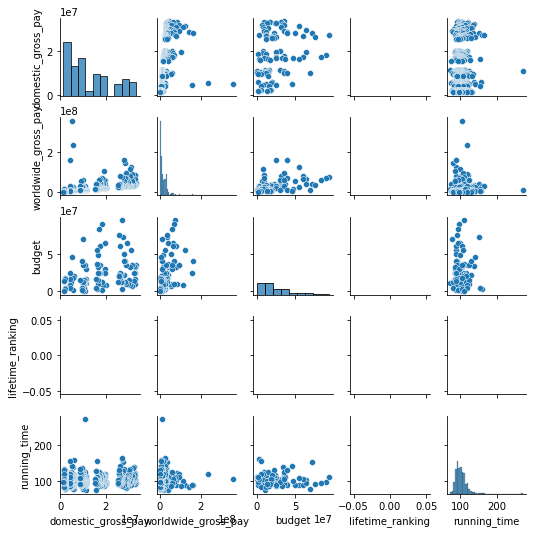

In [17]:
import seaborn as sns
sns.pairplot(copy_movies_page_info, height = 1.5)

In [ ]:
copy_movies_dummies_info = pd.get_dummies(copy_movies_page_info, columns = ['distributor','first_genre'], drop_first = False)
copy_movies_dummies_info.columns

In [18]:
from sklearn.model_selection import train_test_split
X, X_test,y, y_test = train_test_split(copy_movies_dummies_info[[ 'budget',
       'running_time',
       'distributor_Lionsgate', 'distributor_Metro-Goldwyn-Mayer (MGM)',
       'distributor_Miramax', 'distributor_New Line Cinema',
       'distributor_Other_Dist', 'distributor_Paramount Pictures',
       'distributor_Revolution Studios', 'distributor_Screen Gems',
       'distributor_Sony Pictures Entertainment (SPE)',
       'distributor_Twentieth Century Fox', 'distributor_Universal Pictures',
       'distributor_Walt Disney Studios Motion Pictures',
       'distributor_Warner Bros.', 'first_genre_Adventure',
       'first_genre_Biography', 'first_genre_Comedy', 'first_genre_Crime',
       'first_genre_Drama', 'first_genre_Horror', 'first_genre_Action']],copy_movies_dummies_info['domestic_gross_pay'], test_size=0.2,random_state=40)
X.info()

NameError: name 'copy_movies_dummies_info' is not defined

In [ ]:
X['running_time'] = X['running_time'].fillna(X['running_time'].median())
X['budget'] = X['budget'].fillna(X['budget'].median())
X_test['running_time'] = X_test['running_time'].fillna(X['running_time'].median())
X_test['budget'] = X_test['budget'].fillna(X['budget'].median())
X['budget2'] = X['budget']**2
X_test['budget2'] = X_test['budget']**2
X.info()

In [ ]:
features, target = ['budget',
     'running_time',
       'distributor_Lionsgate', 'distributor_Metro-Goldwyn-Mayer (MGM)',
       'distributor_Miramax', 'distributor_New Line Cinema',
       'distributor_Other_Dist', 'distributor_Paramount Pictures',
       'distributor_Revolution Studios', 'distributor_Screen Gems',
       'distributor_Sony Pictures Entertainment (SPE)',
       'distributor_Twentieth Century Fox', 'distributor_Universal Pictures',
       'distributor_Walt Disney Studios Motion Pictures',
       'distributor_Warner Bros.', 'first_genre_Adventure',
       'first_genre_Biography', 'first_genre_Comedy', 'first_genre_Crime',
       'first_genre_Drama', 'first_genre_Fantasy', 'first_genre_Horror',
       'first_genre_Mystery', 'first_genre_Romance', 'first_genre_Sci-Fi',
       'first_genre_Thriller', 'budget2', 'first_genre_Action'],['domestic_gross_pay']
lr_model = LinearRegression()
lr_model.fit(X,y)


In [ ]:
lr_model.score(X,y)

In [ ]:
lr_model.score(X_test,y_test)

In [ ]:
copy_movies_dummies_info.corr()

In [ ]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression, LassoCV, RidgeCV, ElasticNetCV

from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     KFold, GridSearchCV)
X_val.info()

In [ ]:
#Standardize data
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X.values)
X_std = std.transform(X.values)
X_std_test = std.transform(X_test.values)


In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=40)
lin_reg_est = LinearRegression()
scores_train = cross_val_score(lin_reg_est,X,y,cv=kfold)
np.mean(scores)
scores_test = cross_val_score(lin_reg_est,X_test,y_test,cv=kfold)
scores_train
np.mean(scores_train)

In [ ]:
scores_test
np.mean(scores_test)

In [ ]:
#Find LASSO model
import numpy as np
alphavec = 10**np.linspace(-2,2,200)
lasso_model = LassoCV(alphas = alphavec, cv=kfold)
lasso_model.fit(X_std,y)
lasso_model.alpha_
lasso_model.score(X_std,y)


In [ ]:
list(zip(X.columns,lasso_model.coef_))

In [ ]:
test_set_pred = lasso_model.predict(X_std_test)

In [ ]:
#Find Ridge
alphavec = 10**np.linspace(-2,2,200)
ridge_model = RidgeCV(alphas = alphavec, cv=kfold)
ridge_model.fit(X_std_train, y_train)
ridge_model.alpha_
ridge_model.score(X_std_train,y_train)

In [ ]:
list(zip(X_train.columns,ridge_model.coef_))